In [1]:
# Cell 1: Import libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict


In [2]:
import numpy as np
from cluster_quality_metrics import (
    within_cluster_sum_of_squares,
    average_pairwise_similarity,
    inter_cluster_distance,
    overall_average_pairwise_similarity,
    plot_wcss,
    plot_cohesion,
    plot_separation
)

In [3]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from gensim.models import Word2Vec
import gensim.downloader as api

In [5]:
word2vec_model = api.load('word2vec-google-news-300')

In [6]:
word2vec_model = api.load('fasttext-wiki-news-subwords-300') 

In [7]:
def get_word2vec_embedding(text, word2vec_model):
    words = text.split()
    word_vecs = []
    
    for word in words:
        if word in word2vec_model:
             word_vecs.append(word2vec_model[word])
    
    if len(word_vecs) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    # Average the word vectors to get a single vector for the text
    return np.mean(word_vecs, axis=0)


In [8]:

file_path = 'section_3.csv' 
with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
    df = pd.read_csv(f)

# Extract user IDs and text data
user_ids = df['Id']  
text_data1 = df['Please specify your broad areas of interest (keywords only) for the final project (e.g., games, reinforcement learning, computer vision, natural language processing, etc.) in ranked order of preferenc'] 
text_data2 = df['Do you already have one or more specific project ideas? If so, please briefly describe them.�']  # Replace with the actual name of the second text column
text_data2 = text_data2.fillna('')
# Combine the two text columns (you can concatenate them, or choose a different method)
combined_text = text_data1 + " " + text_data2





In [9]:
# Cell 4: Generate Word2Vec embeddings for the combined text data

# Assuming you have combined the text as 'combined_text' from two columns
embeddings = []
for text in combined_text:
    embeddings.append(get_word2vec_embedding(text, word2vec_model))

# Convert the list of embeddings to a NumPy array for clustering
embeddings = np.array(embeddings)


In [10]:
max_size = 4
initial_num_clusters = len(embeddings) // max_size

kmeans = KMeans(n_clusters=initial_num_clusters, random_state=0)
initial_labels = kmeans.fit_predict(embeddings)

cluster_dict = defaultdict(list)
for i, label in enumerate(initial_labels):
    cluster_dict[label].append(i)


In [11]:
# # Function to perform clustering and handle clusters larger than the max size
# def recluster_large_clusters(cluster_dict, embeddings, max_size=4):
#     final_clusters = []
    
#     for cluster_items in cluster_dict.values():
#         # If a cluster is larger than the max size, split it further using KMeans
#         if len(cluster_items) > max_size:
#             sub_embeddings = [embeddings[i] for i in cluster_items]
            
#             # Create a new KMeans model to split large clusters into smaller ones
#             sub_kmeans = KMeans(n_clusters=(len(cluster_items) // max_size) + 1, random_state=0)
#             sub_labels = sub_kmeans.fit_predict(sub_embeddings)
            
#             # Group the sub-clustered items
#             sub_cluster_dict = defaultdict(list)
#             for idx, sub_label in zip(cluster_items, sub_labels):
#                 sub_cluster_dict[sub_label].append(idx)
                
#             # Add the sub-clusters to the final list
#             for sub_cluster_items in sub_cluster_dict.values():
#                 final_clusters.append(sub_cluster_items)
#         else:
#             # If cluster size is within the limit, add it as-is
#             final_clusters.append(cluster_items)
    
#     return final_clusters

In [12]:
from sklearn.cluster import KMeans
from collections import defaultdict

# Function to perform clustering and handle clusters larger than the max size
def recluster_large_clusters(cluster_dict, embeddings, max_size=4):
    final_clusters = []
    
    for cluster_items in cluster_dict.values():
        # If a cluster is larger than the max size, split it further using KMeans
        if len(cluster_items) > max_size:
            # Get embeddings for items in this cluster
            sub_embeddings = [embeddings[i] for i in cluster_items]
            
            # Determine the number of sub-clusters needed
            n_sub_clusters = (len(cluster_items) // max_size) + 1
            
            # Create and fit KMeans to split the large cluster
            sub_kmeans = KMeans(n_clusters=n_sub_clusters, random_state=0)
            sub_labels = sub_kmeans.fit_predict(sub_embeddings)
            
            # Group items by sub-cluster label
            sub_cluster_dict = defaultdict(list)
            for idx, sub_label in zip(cluster_items, sub_labels):
                sub_cluster_dict[sub_label].append(idx)
                
            # Add each sub-cluster to final_clusters, ensuring they meet size requirements
            for sub_cluster_items in sub_cluster_dict.values():
                if len(sub_cluster_items) > max_size:
                    # Recursively split sub-clusters that still exceed max_size
                    split_sub_clusters = recluster_large_clusters({0: sub_cluster_items}, embeddings, max_size)
                    final_clusters.extend(split_sub_clusters)
                else:
                    final_clusters.append(sub_cluster_items)
        else:
            # If the cluster size is within the limit, add it as-is
            final_clusters.append(cluster_items)
    
    return final_clusters

In [13]:
# # Function to combine clusters with fewer than 4 members
# def combine_small_clusters(clusters, embeddings, max_size=4):
#     # Identify clusters with fewer than 4 members
#     small_clusters = [cluster for cluster in clusters if len(cluster) < max_size]
#     remaining_clusters = [cluster for cluster in clusters if len(cluster) == max_size]

#     combined = False  # Track if any clusters are combined
#     new_clusters = remaining_clusters.copy()

#     # For each small cluster, find the most similar cluster and merge
#     for small_cluster in small_clusters:
#         small_embeddings = np.mean([embeddings[i] for i in small_cluster], axis=0)

#         # Find the nearest cluster that still has space to accommodate the small cluster
#         min_distance = float('inf')
#         nearest_cluster = None
#         nearest_cluster_idx = -1
#         for idx, cluster in enumerate(new_clusters):
#             if len(cluster) < max_size:  # Only consider clusters with space
#                 cluster_embeddings = np.mean([embeddings[i] for i in cluster], axis=0)
#                 distance = euclidean_distances([small_embeddings], [cluster_embeddings])[0][0]
#                 if distance < min_distance:
#                     min_distance = distance
#                     nearest_cluster = cluster
#                     nearest_cluster_idx = idx

#         # Merge small cluster with the nearest cluster (but ensure combined cluster does not exceed 4 members)
#         if nearest_cluster is not None and len(small_cluster) + len(nearest_cluster) <= max_size:
#             new_clusters[nearest_cluster_idx].extend(small_cluster)
#             combined = True
#         else:
#             # If no valid merge is found, leave the small cluster as a new independent cluster
#             new_clusters.append(small_cluster)

#     return new_clusters, combined

In [14]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Function to combine clusters with fewer than max_size members
def combine_small_clusters(clusters, embeddings, max_size=4):
    # Identify clusters with fewer than max_size members
    small_clusters = [cluster for cluster in clusters if len(cluster) < max_size]
    remaining_clusters = [cluster for cluster in clusters if len(cluster) == max_size]

    combined = False  # Track if any clusters are combined
    new_clusters = remaining_clusters.copy()

    # For each small cluster, find the most similar cluster to merge with
    for small_cluster in small_clusters:
        # Calculate the centroid of the small cluster
        small_centroid = np.mean([embeddings[i] for i in small_cluster], axis=0)

        # Find the nearest cluster with space available
        min_distance = float('inf')
        nearest_cluster = None
        nearest_cluster_idx = -1

        for idx, cluster in enumerate(new_clusters):
            if len(cluster) < max_size:  # Only consider clusters with available space
                cluster_centroid = np.mean([embeddings[i] for i in cluster], axis=0)
                distance = euclidean_distances([small_centroid], [cluster_centroid])[0][0]
                if distance < min_distance:
                    min_distance = distance
                    nearest_cluster = cluster
                    nearest_cluster_idx = idx

        # Merge small cluster with the nearest cluster (ensuring max_size limit)
        if nearest_cluster is not None and len(small_cluster) + len(nearest_cluster) <= max_size:
            new_clusters[nearest_cluster_idx].extend(small_cluster)
            combined = True
        else:
            # If no valid merge is found, add the small cluster as a new independent cluster
            new_clusters.append(small_cluster)

    return new_clusters, combined

In [15]:
# Perform iterative clustering inside a loop
iteration_count = 0  # Add an iteration counter to prevent infinite loops
max_iterations = 50  # Set a maximum number of iterations to avoid infinite loops

while iteration_count < max_iterations:
    iteration_count += 1
    
    # Re-cluster large clusters
    new_clusters = recluster_large_clusters(cluster_dict, embeddings, max_size=max_size)

    # Combine small clusters with their nearest neighbors
    final_clusters, combined = combine_small_clusters(new_clusters, embeddings, max_size=max_size)

    # Debug: Print the sizes of all clusters after each iteration
    print(f"Iteration {iteration_count} cluster sizes: {[len(c) for c in final_clusters]}")
    
    # Check if all clusters are now size 4
    if all(len(cluster) == max_size for cluster in final_clusters):
        break  # Exit the loop if all clusters have exactly 4 members
    
    # If no changes were made, stop the loop to avoid infinite looping
    if not combined:
        print("No further changes detected, stopping iteration.")
        break

    # Update cluster_dict for the next iteration
    cluster_dict = defaultdict(list)
    for i, cluster in enumerate(final_clusters):
        for item in cluster:
            cluster_dict[i].append(item)


Iteration 1 cluster sizes: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4]
Iteration 2 cluster sizes: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]
No further changes detected, stopping iteration.


In [16]:
# Flatten the clusters and assign final labels
final_cluster_labels = np.zeros(len(combined_text), dtype=int)

# **Fix for Label Assignment**
# Ensure that each cluster gets a unique ID and all points are labeled correctly
for cluster_id, cluster_items in enumerate(final_clusters):
    for item in cluster_items:
        final_cluster_labels[item] = cluster_id

In [17]:
# Assign the final cluster labels and save to CSV
df['cluster'] = final_cluster_labels
df_sorted = df.sort_values(by='cluster')
df_sorted.to_csv('result_3/final_word2vec_Kmeans_clusters.csv', index=False)

print("Clustering using Word2Vec completed and saved to final_word2vec_clusters.csv")

Clustering using Word2Vec completed and saved to final_word2vec_clusters.csv


WCSS per cluster: {0: 0.10289906070543611, 1: 0.08528273967200568, 2: 0.08605186974308565, 3: 0.04296470705087777, 4: 0.07617268530840458, 5: 0.0645423449674163, 6: 0.17406825104947865, 7: 0.17668039632504742, 8: 0.44304520234736333, 9: 0.37637919837168465, 10: 0.1812229402367166, 11: 0.09487702930594172, 12: 0.3504033796518415, 13: 0.28465069682968486, 14: 0.7540007615527966, 15: 0.167032970833913, 16: 0.10027568760426492, 17: 0.5830240260740089, 18: 0.4739371356981285, 19: 0.15112909783037398, 20: 0.28909131844389396, 21: 0.3773650512797626, 22: 1.0258415001849428, 23: 0.6162985256480122, 24: 0.21230264165475182, 25: 0.7178194001131518}


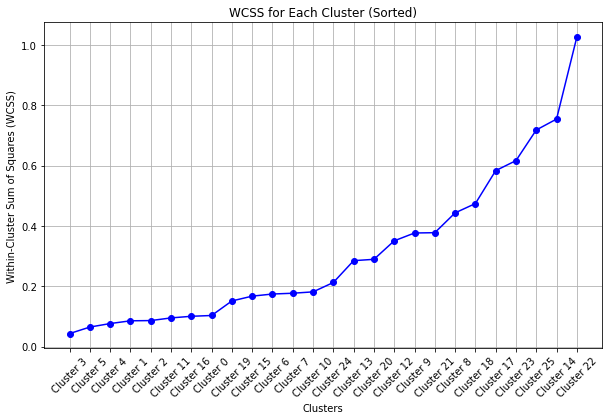

Cohesion per cluster: {0: 0.8934983988497489, 1: 0.921235144839413, 2: 0.9321393189916445, 3: 0.9634448887731444, 4: 0.9350268132799125, 5: 0.9292408571841868, 6: 0.8594756303542415, 7: 0.9218415973732942, 8: 0.7217349185795664, 9: 0.7937191956127432, 10: 0.8042541895059503, 11: 0.9299292368601128, 12: 0.7267945701449495, 13: 0.7406638819924608, 14: 0.49152913181938684, 15: 0.8911854726502254, 16: 0.9243259700184588, 17: 0.7782408434941583, 18: 0.753898612619834, 19: 0.8664426610787211, 20: 0.7525598908494765, 21: 0.6769238066001817, 22: 0.648119122342475, 23: 0.29464371801140055, 24: 0.8934776175338929, 25: 0.6837919073973998}


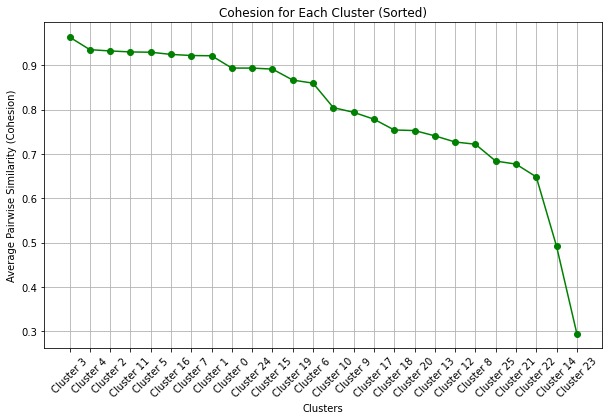

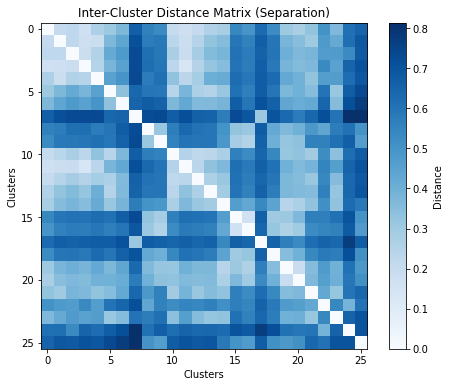

Overall Average Pairwise Similarity: 0.7994604487473834


In [18]:
embeddings_np = np.array(embeddings)
# Calculate WCSS and plot
wcss_per_cluster = within_cluster_sum_of_squares(embeddings_np, final_clusters)
print("WCSS per cluster:", wcss_per_cluster)
plot_wcss(wcss_per_cluster)


# Calculate Cohesion and plot
cohesion_per_cluster = average_pairwise_similarity(embeddings, final_clusters)
print("Cohesion per cluster:", cohesion_per_cluster)
plot_cohesion(cohesion_per_cluster)

# Calculate Inter-Cluster Distance (Separation) and plot
separation_matrix = inter_cluster_distance(embeddings, final_clusters)
# print("Inter-Cluster Distance Matrix:\n", separation_matrix)
plot_separation(separation_matrix)

# Calculate Overall Average Pairwise Similarity
overall_similarity = overall_average_pairwise_similarity(embeddings, final_clusters)
print("Overall Average Pairwise Similarity:", overall_similarity)

**Using FAISS from here on**

In [19]:
pip install faiss-cpu


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import faiss

In [21]:
max_size = 4

# Function to perform clustering using Faiss and explicitly merge small clusters
def faiss_clustering_with_merging(embeddings, max_size=4):
    """
    Perform clustering using Faiss and actively merge small clusters.
    Args:
        embeddings: List of sentence embeddings.
        max_size: Maximum size of each cluster.
    Returns:
        List of clusters with merged small clusters.
    """
    n_samples = len(embeddings)
    embedding_dim = len(embeddings[0])  # Dimensionality of embeddings

    # Build Faiss index
    index = faiss.IndexFlatL2(embedding_dim)  # Using L2 (Euclidean distance)
    index.add(np.array(embeddings))  # Add all embeddings to the index

    # Find clusters using nearest neighbors
    visited = set()
    clusters = []

    for i in range(n_samples):
        if i not in visited:
            # Query nearest neighbors
            distances, neighbors = index.search(np.array([embeddings[i]]), max_size)
            neighbors = neighbors.flatten()
            # Only take unvisited neighbors
            cluster = [n for n in neighbors if n not in visited]
            clusters.append(cluster)
            visited.update(cluster)

    # Step 2: Actively merge small clusters with each other
    final_clusters = []
    small_clusters = [c for c in clusters if len(c) < max_size]
    full_clusters = [c for c in clusters if len(c) == max_size]

    while small_clusters:
        current_cluster = small_clusters.pop(0)

        # Try to merge the current small cluster with another small cluster
        merged = False
        for other_cluster in small_clusters:
            if len(current_cluster) + len(other_cluster) <= max_size:
                current_cluster.extend(other_cluster)
                small_clusters.remove(other_cluster)  # Remove the merged cluster
                merged = True
                break

        # If merged successfully or couldn't be merged further, add it to final clusters
        if len(current_cluster) <= max_size:
            final_clusters.append(current_cluster)
        else:
            # If merging exceeded the size limit, split and handle separately
            final_clusters.append(current_cluster[:max_size])
            remaining_part = current_cluster[max_size:]
            small_clusters.insert(0, remaining_part)  # Re-add remaining part as a new cluster

    final_clusters.extend(full_clusters)  # Add the already full clusters

    return final_clusters

In [22]:
# Perform clustering using Faiss with active merging
clusters = faiss_clustering_with_merging(embeddings, max_size=max_size)

# Debug: Print cluster sizes
print(f"Generated {len(clusters)} clusters. Cluster sizes: {[len(c) for c in clusters]}")

# Assign cluster labels to the DataFrame
final_cluster_labels = np.zeros(len(combined_text), dtype=int)

for cluster_id, cluster_items in enumerate(clusters):
    for item in cluster_items:
        final_cluster_labels[item] = cluster_id

# Add the new cluster labels to the DataFrame
df['cluster'] = final_cluster_labels

# Sort the DataFrame by cluster labels
df_sorted = df.sort_values(by='cluster')

# Save the sorted DataFrame to a new CSV file
df_sorted.to_csv('result_1/faiss_word2vec.csv', index=False)

print("Clustering completed with active merging and saved to faiss_clustered_data_with_merging.csv")


Generated 30 clusters. Cluster sizes: [3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 3, 3, 3, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4]
Clustering completed with active merging and saved to faiss_clustered_data_with_merging.csv


WCSS per cluster: {0: 0.26293201219178247, 1: 0.16876336209515147, 2: 0.11705101680242778, 3: 0.08972140915548676, 4: 0.19495298253103477, 5: 0.3260242920384624, 6: 0.1789101528281092, 7: 1.2657064393174067, 8: 0.37443689947677694, 9: 1.1081444030895562, 10: 0.47792028791476315, 11: 0.6852920399693987, 12: 0.10699436299788682, 13: 0.3163179834870825, 14: 0.11888484650851452, 15: 0.2501010133411513, 16: 0.06455872947756053, 17: 0.6712722939160284, 18: 0.5141095898197053, 19: 0.2135613909368453, 20: 0.5875574873586227, 21: 0.0, 22: 0.4083670875821817, 23: 0.08605869589463004, 24: 0.08730375380789032, 25: 0.07584926323647699, 26: 0.10388736502217118, 27: 0.17668039632504745, 28: 0.08605186974308565, 29: 0.3842452028229935}


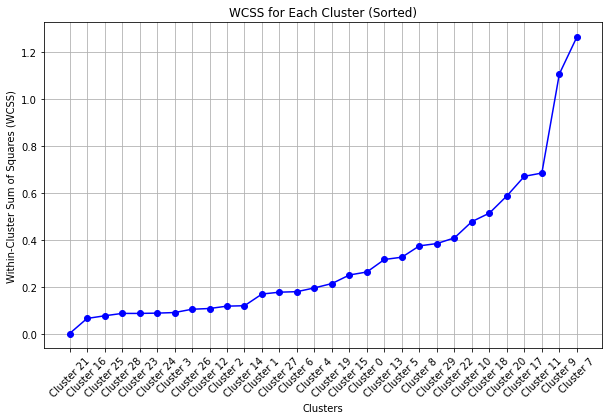

Cohesion per cluster: {0: 0.6890936025174561, 1: 0.8274641535745877, 2: 0.8733812256407129, 3: 0.9189963353460565, 4: 0.8462943646569582, 5: 0.6967189620597551, 6: 0.7974528492434084, 7: 0.588405203987982, 8: 0.6590842532924817, 9: 0.5503780224332943, 10: 0.6549964328184589, 11: 0.6146790465105157, 12: 0.8728233501702221, 13: 0.6946892733650184, 14: 0.7278147474610561, 15: 0.5947932979887836, 16: 0.8171097083480773, 17: 0.6032624174899596, 18: 0.2449833519700526, 19: 0.7262353045246029, 20: 0.4621283558985594, 21: 1.0, 22: 0.6678397444857752, 23: 0.9465183464804646, 24: 0.9033745792357539, 25: 0.9274967867613957, 26: 0.9103005352810457, 27: 0.9218415973732941, 28: 0.9321393189916444, 29: 0.8136875798501247}


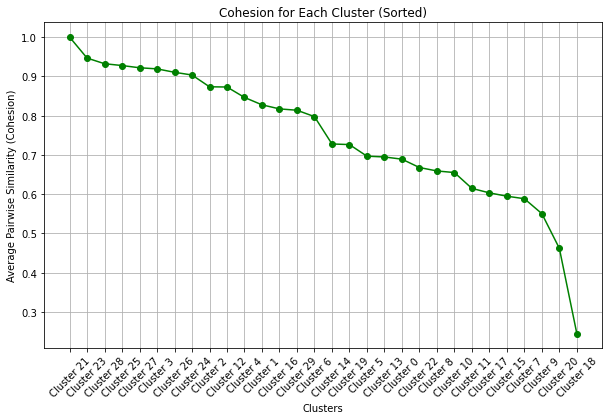

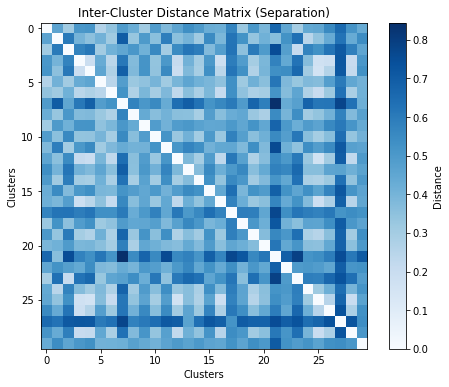

Overall Average Pairwise Similarity: 0.7607816079468567


In [23]:
embeddings_np = np.array(embeddings)
# Calculate WCSS and plot
wcss_per_cluster = within_cluster_sum_of_squares(embeddings_np, clusters)
print("WCSS per cluster:", wcss_per_cluster)
plot_wcss(wcss_per_cluster)


# Calculate Cohesion and plot
cohesion_per_cluster = average_pairwise_similarity(embeddings, clusters)
print("Cohesion per cluster:", cohesion_per_cluster)
plot_cohesion(cohesion_per_cluster)

# Calculate Inter-Cluster Distance (Separation) and plot
separation_matrix = inter_cluster_distance(embeddings, clusters)
# print("Inter-Cluster Distance Matrix:\n", separation_matrix)
plot_separation(separation_matrix)

# Calculate Overall Average Pairwise Similarity
overall_similarity = overall_average_pairwise_similarity(embeddings, clusters)
print("Overall Average Pairwise Similarity:", overall_similarity)